In [1]:
# ! pip install shap keras tensorflow

# Model definition

## Settings

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import helpers.settings as sts
sts.print_settings(sts)

BEST_ESTIMATOR_FILENAME : best_estimator_0.0.1.pkl
DATASET_TRAIN_FILENAME : dataset_train.parquet
DATASET_VALIDATION_FILENAME : dataset_validation.parquet
ETL_VERSION : 0.0.1
MODEL_FILENAME : model.pkl
MODEL_VERSION : 0.0.1
PREPROCESSOR_FILENAME : preprocessor_0.0.1.pkl
TRAINED_BEST_ESTIMATOR_FILENAME : trained_best_estimator_0.0.1.pkl
color : <class 'helpers.settings.color'>
print_settings : <function print_settings at 0x7f7fc02b5ee0>



## Imports

In [35]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    plot_precision_recall_curve,
    precision_recall_curve,
    average_precision_score,
    plot_confusion_matrix,
)
import re
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import shap
import matplotlib.pyplot as plt  
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

##  Load dataset

In [6]:
df_train = pd.read_parquet(f"data/{sts.DATASET_TRAIN_FILENAME}")

In [7]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

## Load preprocessor

In [8]:
with open(f"artifacts/{sts.PREPROCESSOR_FILENAME}","rb") as file:
    preprocessor = pickle.load(file)

## Deep Learning

In [28]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])
    return model

In [29]:
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=20, verbose=1)

## Model testing

In [36]:
estimators = [
    {
        "clf": [XGBClassifier()],
    },
    {
        "clf": [LGBMClassifier()],
    },
    {
        "clf": [SVC()],
    },
    {
        "clf": [RandomForestClassifier()],
    },
    {
        "clf": [AdaBoostClassifier()],
    },
    {
        "clf": [MLPClassifier()],
    },
]

In [41]:
clf_deep_learning = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", model),
    ]
)

In [46]:
model.fit(preprocessor.transform(X_train),y_train)

Epoch 1/6


ValueError: in user code:

    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_18 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape (None, 16)


In [31]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier()),
    ],
)

In [32]:
gs = GridSearchCV(
    clf,
    estimators,
    scoring="average_precision",
    cv=5,
    n_jobs=1, 
    verbose=0,
)

In [33]:
gs.fit(X_train, y_train)

[00:00:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:00:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:00:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ModifiedColumnTransformer(categorical_features=['CODE_GENDER',
                                                                                        'FLAG_OWN_CAR',
                                                                                        'FLAG_OWN_REALTY',
                                                                                        'NAME_INCOME_TYPE',
                                                                                        'NAME_EDUCATION_TYPE',
                                                                                        'NAME_FAMILY_STATUS',
                                                                                        'NAME_HOUSING_TYPE',
                                                                                        'FLAG_MOBIL',
                                                                       

In [34]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.set_index(cv_results["param_clf"].apply(lambda x: f"{x}"[:7]), inplace=True)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
param_clf,,,,,,,,,,,,,,
XGBClas,0.993541,0.022941,0.048961,0.005254,"XGBClassifier(base_score=None, booster=None, c...","{'clf': XGBClassifier(base_score=None, booster...",0.876223,0.888291,0.818307,0.869002,0.899438,0.870252,0.027974,2
LGBMCla,0.524127,0.057888,0.050050,0.001747,LGBMClassifier(),{'clf': LGBMClassifier()},0.868911,0.865323,0.823691,0.878466,0.881940,0.863666,0.020887,3
SVC(),1.046007,0.120550,0.456397,0.024179,SVC(),{'clf': SVC()},0.012952,0.016935,0.010371,0.015351,0.015957,0.014313,0.002368,5
RandomF,1.427074,0.014256,0.084071,0.001455,RandomForestClassifier(),{'clf': RandomForestClassifier()},0.887635,0.918602,0.852309,0.884367,0.917482,0.892079,0.024534,1
AdaBoos,0.747027,0.007506,0.055993,0.001544,AdaBoostClassifier(),{'clf': AdaBoostClassifier()},0.049564,0.041454,0.043948,0.080117,0.044713,0.051959,0.014322,4
<keras.,0.319252,0.008211,0.000000,0.000000,<keras.wrappers.scikit_learn.KerasClassifier o...,{'clf': <keras.wrappers.scikit_learn.KerasClas...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


<AxesSubplot:>

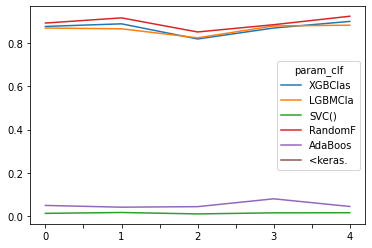

In [16]:
cv_results_splits = cv_results[[col for col in cv_results.columns if "split" in col]]
cv_results_splits.columns = [re.sub("[^0-9]", "", col) if "split" in col else col for col in cv_results_splits.columns]
cv_results_splits.T.plot()

In [17]:
y_proba = gs.best_estimator_.predict_proba(X_train)[:,1]
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [18]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30584
           1       0.96      0.96      0.96       404

    accuracy                           1.00     30988
   macro avg       0.98      0.98      0.98     30988
weighted avg       1.00      1.00      1.00     30988



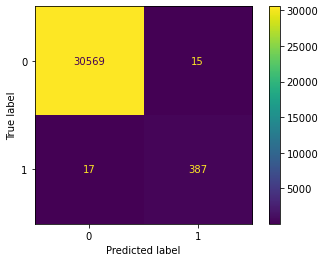

In [19]:
plot_confusion_matrix(gs.best_estimator_, X_train, y_train)

## Dump best estimator

In [20]:
with open(f"artifacts/{sts.BEST_ESTIMATOR_FILENAME}","wb") as file:
    pickle.dump(gs.best_estimator_, file)